# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### Algorithm to Use: MADDPG

We have just implemented Deep Deterministic Policy Gradients (DDPG), a actor-critic algorithm or a DQN method for continuous control project. Thus, it is easy to use Multi-Agent Deep Deterministic Policy Gradients (MADDPG) to solve this problem.

The below gives the general information about this algorithm:

The actor approximates the optimal policy deterministically and output the best believed action for any given state. The critic learns the optimal value function by using the actors best believed action. There are two main features of DDPG:

- experience reply buffer which refers to learn from the previous experience (memory), as in DQN. We set a Reply buffer with fixed size (BUFFER_SIZE) and stored the experiences in the buffer. When updating the parameters, we sample a few (batch_size) memory from the buffer. In this way, we can break the sequential nature of experiences and stabilize the learning algorithm.
- soft updates to the target networks
    
    Note: there are 4 neural networks:
        - two regular networks (like the local/evaluate network in DQN whose parameters update all the time): one for the actor and one for the critic
        - two target networks (like the target network in DQN whose parameters update after a certain steps): one for the actor and one for the critic
    The target networks update using a soft updates strategy, e.g, when updating the target network $\theta_{target}$, 
    $$\theta_{target} = \tau \cdot \theta_{local} + (1 - \tau)\cdot \theta_{target} $$
    Here, $\tau \leq 1$ and $\theta_{target}$ can be for either actor target network or critic target network. 

#### Extended idea

When solving the first project: Banana, I have tried to use prioritized experience reply with different DQN based methods. The results showed that with prioritized experience reply, less episodes are needed for solving a problem. I would like also to integrate prioritized experience reply with DDPG and compare it to DDPG without prioritized experience reply. 

Note: with prioritized experience reply in DQN, we selects the sample according to the priorities (https://arxiv.org/pdf/1511.05952.pdf). Samples drawn from the buffer are fed into the DQN algorithm before getting priorities based on the magnitude of TD error. There are two additional hyperparameters $\alpha$ and $\beta$ for controlling how much prioritized experience replay affects the sampling distribution and network parameter updates.



#### Define MADDPG run pipeline

In [5]:
# import
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchviz import make_dot

from ddpg_agent_per import Agent
from model import Actor, Critic

import time
import pickle
import pandas as pd

`ddpg_agent_per` contains `Agent` class, e.g., 
```python
Agent(n_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=0)
```

In MADDPG `Agent` class, the architect of the neural networks look like below:
- The actor network
    
    It builds an actor (policy) network that maps states -> actions
    - The model has batch normalization and 3 fully connected layers
    - The first layer takes in the state (batch normalized) passes it through 256 nodes with Leaky ReLu activation
    - The second layer take the output from first layer and passes through 128 nodes with Leaky ReLu activation
    - The third layer takes the output from the previous layer and outputs the action size with Tanh activation 
    - Adam optimizer.

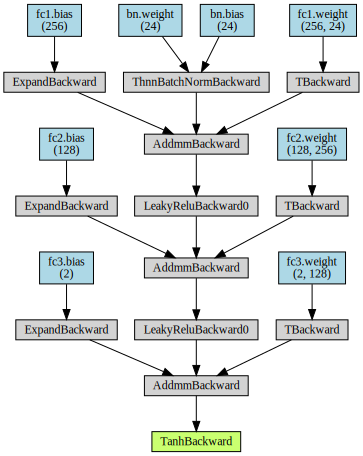

In [6]:
model = Actor(state_size, action_size)
model.eval()
x = Variable(torch.randn(1,state_size))
y = model(x)
             
make_dot(y, params=dict(list(model.named_parameters())))

- the critic network
  
  Build a critic (value) network that maps (state, action) pairs -> Q-values.
    - The model has batch normalization and 4 fully connected layers
    - The first layer takes the state (batch normalized) and passes through 256 nodes with Leaky ReLu activation
    - Then we take the output from the first layer and concatenate it with the action size
    - We then pass this to second layer which forwards through 128 nodes with Leaky ReLu activation
    - The third layer takes the output from the previous layer passes it through 128 nodes with Leaky ReLu activation
    - The fourth layer take the previous layer outputs 1
    - Adam optimizer

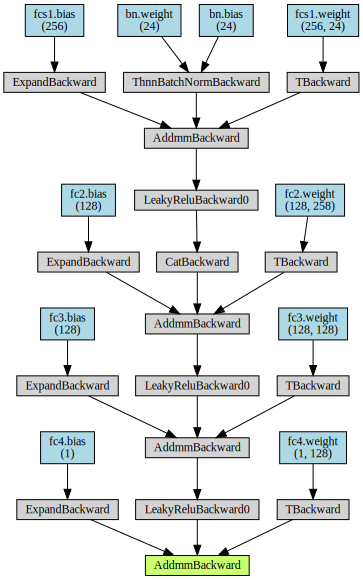

In [7]:
model = Critic(state_size, action_size, seed=0)
model.eval()
x = Variable(torch.randn(1,state_size))
z = Variable(torch.randn(1,action_size))
y = model(x, z)
             
make_dot(y, params=dict(list(model.named_parameters())))

In [8]:
def maddpg_train(env = None,
                 agent = None,
                 num_agents = 1,
                 n_episodes=2000,
                 window_size=100, 
                 score_threshold=30.0, 
                 print_every=50, 
                 prioritized_reply=False):
    """
    Params
    ======
        env: environment
        agent: agent class
        num_agents (int): number of agents
        n_episodes (int): maximum number of training episodes
        window_size (int): window size used to get last window_size scores
        score_threshold (float): minimum value to reach (required by the project assinment)
        print_every (float): print out every print_every episodes
        prioritized_reply (bool): True or False for using prioritized reply buffer, default is False
    """

    scores_deque = deque(maxlen=window_size) # last window_size scores
    scores = []        
    
    n_episode_reach_requirement = None # in how many episode, the problem is solved
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        episode_scores = np.zeros(num_agents) 

        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, dones)
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break
                
        episode_score = np.mean(episode_scores)
        scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)

        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))

        if average_score >= score_threshold:
            if n_episode_reach_requirement is None:
                n_episode_reach_requirement = i_episode - window_size
                print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), ''.join('checkpoint_actor.pth'))
            torch.save(agent.critic_local.state_dict(), ''.join('checkpoint_critic.pth'))

    return scores, n_episode_reach_requirement

The other hyper-parameters which are not seen in notebook but in .py files are

- BUFFER_SIZE: int(1e6)  # replay buffer size
- BATCH_SIZE: 128        # minibatch size
- GAMMA: 0.99            # discount factor
- TAU: 1e-3              # for soft update of target parameters
- LR_ACTOR = 1e-4        # learning rate of the actor 
- LR_CRITIC = 3e-4       # learning rate of the critic
- UPDATE_EVERY = 20      # how often to update the network
- LEAKINESS = 0.01       # leaky in Leaky ReLu

#### Training

In [10]:
s = dict()
n_episodes = dict()
prioritized_replys = [False, True]
for prioritized_reply in prioritized_replys:
    print("Start training with prioritized experience reply =", prioritized_reply)
    agent = Agent(n_agents=num_agents, state_size=state_size, action_size=action_size, 
                  random_seed=42, prioritized_reply=prioritized_reply)
    scores, n_episode_reach_requirement = maddpg_train(env = env, agent = agent, 
                                                       num_agents = num_agents,
                                                       n_episodes=300,
                                                       window_size=100, score_threshold=30.0, 
                                                       print_every=10, prioritized_reply=prioritized_reply)
    
    s["".join("prioritized_experience_reply_"+str(prioritized_reply))] = scores
    n_episodes["".join("prioritized_experience_reply_"+str(prioritized_reply))] = n_episode_reach_requirement
    print("\n\n")

# save the scores and the number of episodes required to solve the problem
with open('training_scores.pickle', 'wb') as handle:
    pickle.dump(s, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('training_solved_in_n_episodes.pickle', 'wb') as handle:
    pickle.dump(n_episodes, handle, protocol=pickle.HIGHEST_PROTOCOL)

Start training with prioritized experience reply = False


ValueError: operands could not be broadcast together with shapes (2,2) (20,2) (2,2) 

#### Plots

In [ ]:
for method, scores in s.items(): 
    print(method, "solved the problem in", n_episodes[method], 'episodes')
    # plot the scores
    plt.plot(np.arange(len(scores)), scores, label = method)
    plt.ylabel('Average score')
    plt.xlabel('Number of episode')
    plt.title(method)
    plt.savefig("".join(method+"traning_plot.pdf"))
    plt.show()
    print("\n\n")

In [ ]:
score_df = pd.DataFrame(s)
fig, ax = plt.subplots()
score_df.rolling(10).mean().dropna().plot(ax=ax)
ax.set_xlabel("Number of episode")
ax.set_ylabel("Average score")
fig.suptitle("DDPG training in Continuous Control")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("multiple_traning_plots.pdf")
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()